In [3]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')

import hipy.pltext       as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np

from src.read_data import process_and_write_parts, load_concatenated, read_parquet
from wcte.brbtools import sort_run_files, get_part_files, select_good_parts
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# ============= LOADS THE DATA ===================
run  = 1728
data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/tmp_parquet/{run}")

In [5]:
# =============== MASK OUT CARDS 130-132 ===================
run_cards, run_times, run_events, run_charges = read_parquet(data, mask=True)

In [6]:
hit_times = ak.sort(run_times)

In [7]:
len(hit_times)

47110

In [8]:
# # ============ nHITS TRIGGER ALGORITHM ITSELF ================================
# # ============ FIRST VERSION: 1 TRIGGER PER READOUT WINDOW ===================

# nevents = len(hit_times)
# triggered_hits_index = {}

# for event in tqdm(range(nevents), total=nevents):
#     ht = ak.to_numpy(ak.sort(hit_times[event]))
#     w = 200
#     t = 20
#     pre_window = 50
#     post_window = 100

#     # Sliding window trigger
#     starts = ht
#     ends   = ht + w
#     right  = np.searchsorted(ht, ends, side="left")
#     left   = np.arange(len(ht))
#     counts = right - left

#     # Detection of the first trigger
#     threshold_mask = (counts > t)
#     if np.any(threshold_mask):
#         trigger_index = np.where(threshold_mask)[0][0]
#         time_triggered = ht[trigger_index]

#         # Window centered in the trigger
#         t_min = time_triggered - pre_window
#         t_max = time_triggered + post_window

#         indices_in_window = np.where((ht >= t_min) & (ht < t_max))[0]
#         hits_in_window = ht[indices_in_window]

#         # print("Trigger en:", time_triggered)
#         # print("Índice del trigger:", trigger_index)
#         # print("Índices en la ventana centrada:", indices_in_window)
#         # print("Hits en la ventana centrada:", hits_in_window)
#         # print(f"Event {event} triggered")
#         triggered_hits_index[event] = indices_in_window
#     else:
#         None
#         # print(f"Event {event} did not trigger")

In [8]:
# # Sort by number of hits in the window
# top5 = sorted(triggered_hits_index.items(), key=lambda x: len(x[1]), reverse=True)[:5]

# # Print 5 windows with the bigger amount of hits
# for i, (event_id, indices) in enumerate(top5, 1):
#     print(f"{i}. Evento {event_id} con {len(indices)} hits")

In [9]:
# event = 243
# pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=True, label=f"Hits In Event {event} nHits Triggered", formate=".2e");
# pltext.hist(hit_times[event], 100, ylog=True, xylabels=("Time [ns]"), label=f"Hits In Event {event}", formate=".2e");

In [10]:
# pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Time [ns]"), label=f"Hits In Event {event} nHits Triggered", formate=".2e");

In [11]:
# pltext.hist(hit_charges[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Charge"), label=f"Hits In Event {event} nHits Triggered", formate=".2e");

In [27]:
# ============ SECOND VERSION: AS MUCH TRIGGERS PER READOUT WINDOW AS WE FIND ===================
nevents = len(hit_times)
triggered_hits_index = {}

w = 100             # ns
t = 10             # hits
pre_window  = 10000 # ns
post_window = 10000 # ns
jump = 15000       # ns Trigger dead time (expected time between events)

# Run the algorithm for every readout window
for event in tqdm(range(nevents), total=nevents):
    ht = ak.to_numpy(hit_times[event])
    if len(ht) == 0: # Skip if event empty
        continue
    
    # Count hits in window
    ends   = ht + w
    right  = np.searchsorted(ht, ends, side="left")
    left   = np.arange(len(ht))
    counts = right - left

    # Get the indices of all the hit times that triggered the nHits algorithm
    trigger_indices = np.where(counts > t)[0]
    if len(trigger_indices) == 0: # Skip if no triggers in event
        continue

    event_hits = []
    last_trigger_time = -np.inf  # First trigger always need to exist

    # Search for the rest of the hits in the trigger
    for idx in trigger_indices:
        time_triggered = ht[idx]

        # If we are inside the dead time, ignore this trigger
        if time_triggered < last_trigger_time + jump:
            continue

        # Window centered in the first hit that trigger the algorithm
        t_min = time_triggered - pre_window
        t_max = time_triggered + post_window
        indices_in_window = np.where((ht >= t_min) & (ht < t_max))[0]
        event_hits.append(indices_in_window) # Append hit_times of the trigger

        # Update last valid trigger time
        last_trigger_time = time_triggered

    # Update dictionary
    if len(event_hits) > 0:
        triggered_hits_index[event] = event_hits


  0%|          | 0/47110 [00:00<?, ?it/s]

In [28]:
triggered_hits_index.keys()

dict_keys([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 28, 29, 30, 33, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 60, 62, 63, 64, 66, 67, 69, 71, 72, 73, 76, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 141, 142, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 160, 161, 162, 163, 164, 165, 166, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 183, 184, 186, 187, 191, 192, 193, 195, 196, 197, 198, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 218, 219, 220, 221, 222, 224, 226, 227, 228, 230, 231, 232, 233, 234, 235, 237, 238, 239, 241, 242, 243, 244, 245, 246, 249, 251, 252, 254, 256, 257, 258, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 279

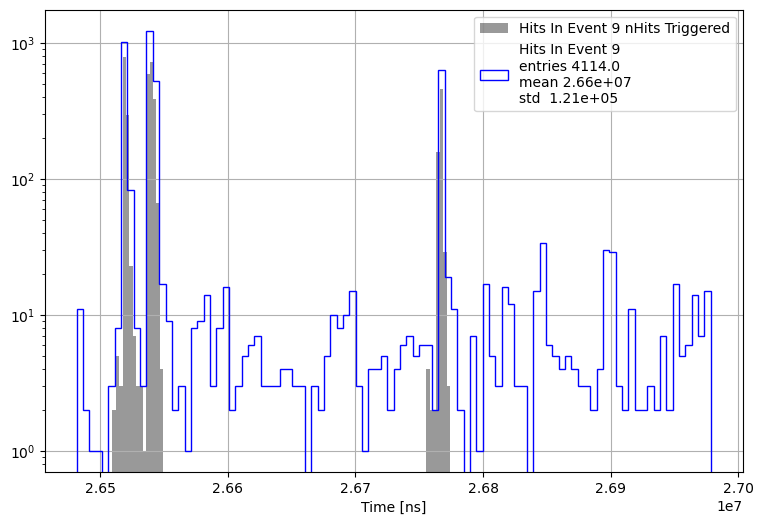

In [29]:
# Some Plots 
event = 9
triggered_hits = np.concatenate(triggered_hits_index[event])

fig = plt.figure(figsize=(9,6))
pltext.hist(hit_times[event][triggered_hits], 100, ylog=True, 
            stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
            histtype="stepfilled", alpha=0.4);
pltext.hist(hit_times[event], 100, ylog=False, xylabels=("Time [ns]"), stats=True, label=f"Hits In Event {event}", formate=".2e");

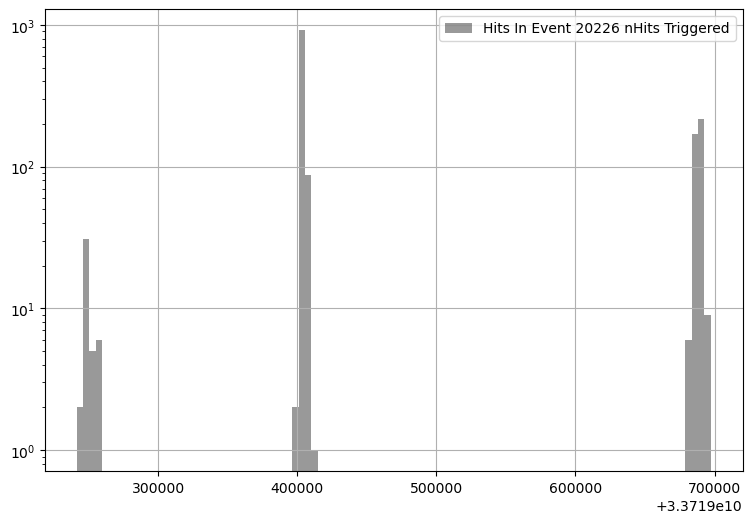

In [50]:
event = 20226
triggered_hits = np.concatenate(triggered_hits_index[event])

fig = plt.figure(figsize=(9,6))
pltext.hist(hit_times[event][triggered_hits], 100, ylog=True, 
            stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
            histtype="stepfilled", alpha=0.4);

In [51]:
ak.min(hit_times[event][triggered_hits_index[event][1]]) - ak.max(hit_times[event][triggered_hits_index[event][0]])

137589.27212905884

In [31]:
d = list(triggered_hits_index.keys())
indices = np.linspace(0, len(d) - 1, 8).astype(int)
valid_events = [d[i] for i in indices]

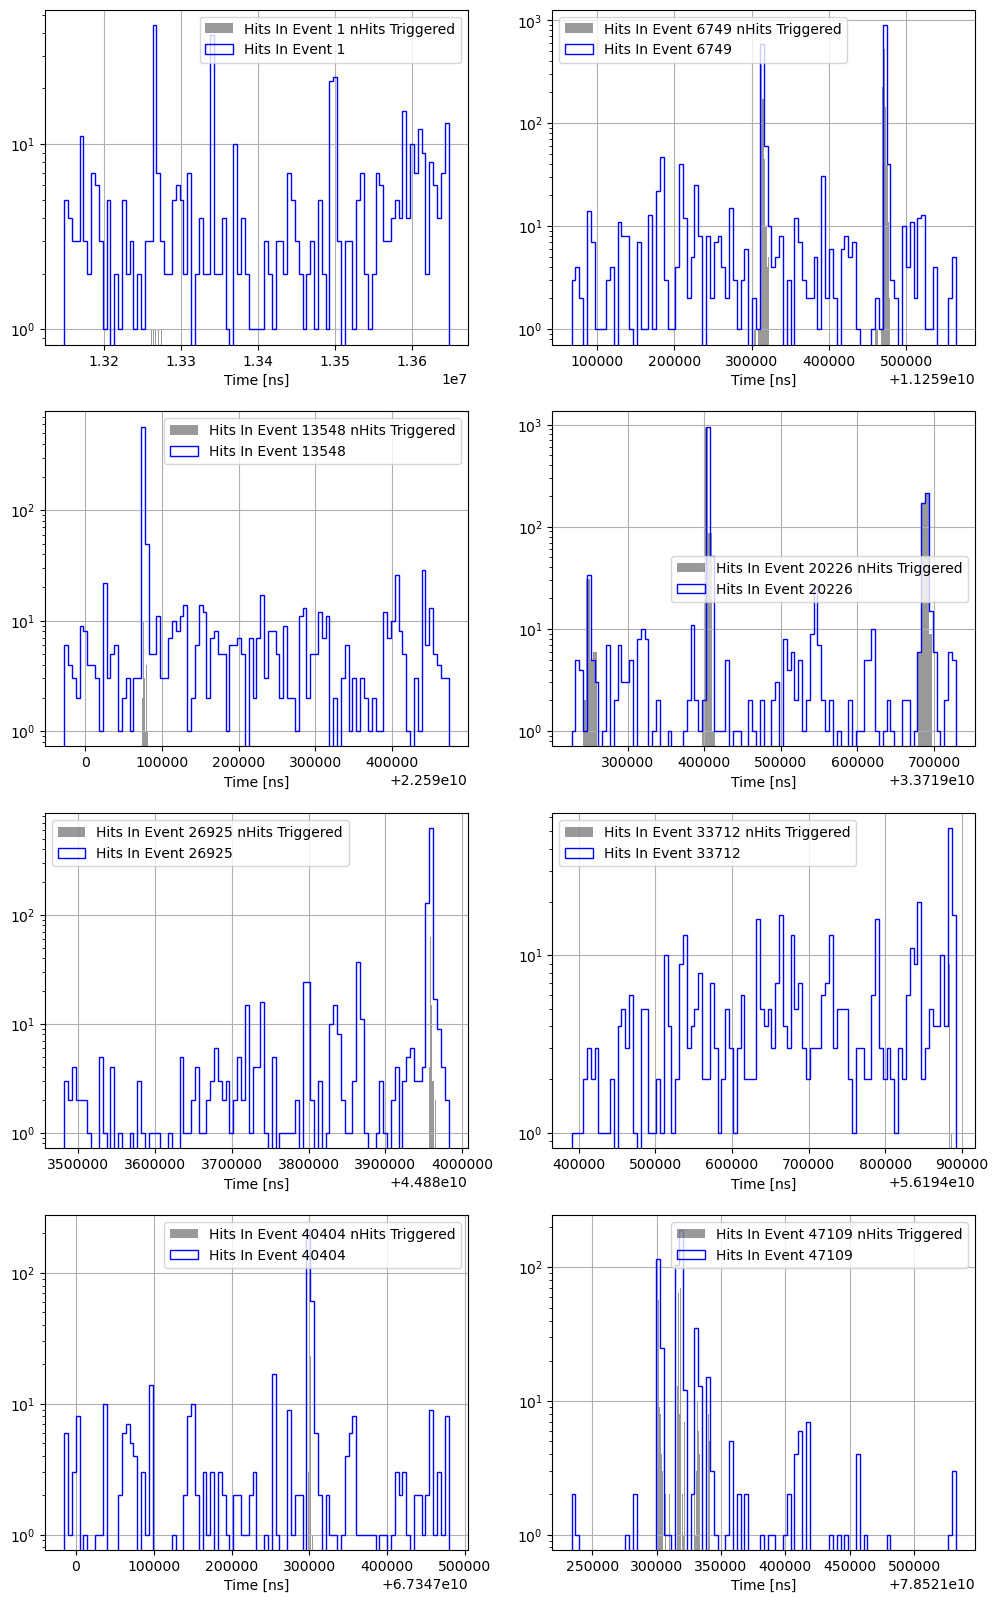

In [32]:
subplot = pltext.canvas(8)

for i, event in enumerate(valid_events):
    triggered_hits = np.concatenate(triggered_hits_index[event])
    subplot(i+1)
    pltext.hist(hit_times[event][triggered_hits], 100, ylog=True, 
                stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
                histtype="stepfilled", alpha=0.4);
    pltext.hist(hit_times[event], 100, ylog=True, xylabels=("Time [ns]"), stats=False, label=f"Hits In Event {event}", formate=".2e");